In [1]:
using Plots, Printf, DelimitedFiles, BenchmarkTools, FFTW
using Revise
using MDToolbox
ENV["COLUMNS"] = 130

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1260
┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/WkyNB/src/Revise.jl:1167
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


130

In [21]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/3gb1.pdb");

In [27]:
model_array = model_array["atomname CA"];
decenter!(model_array);

# 並進などのテスト

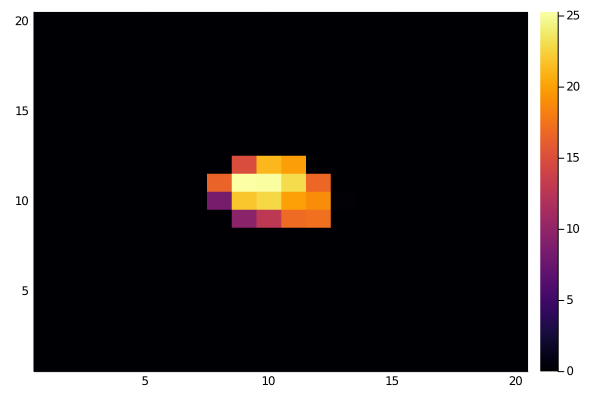

In [49]:
pdbRotated = MDToolbox.rotate(model_array[1, :], q_array[7, :])
calculated = afmize(pdbRotated, MDToolbox.defaultConfig())
observed = calculated
heatmap(observed)

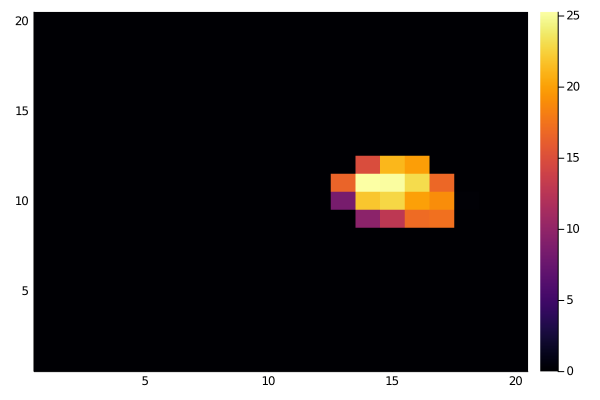

In [50]:
observed_translated = translateafm(observed, (0, 5))
heatmap(observed_translated)

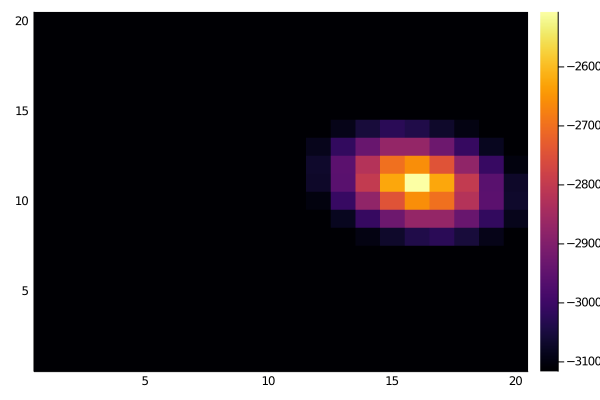

In [62]:
observed_translated = observed_translated .- 100.0
C_o  = sum(observed_translated)
C_c  = sum(calculated)
#@btime C_oc = sum(observed_translated .* calculated)
C_oc = sum(observed_translated .* calculated)
C_cc = sum(calculated.^2)
C_oo = sum(observed_translated.^2)
#@btime C_oc_dxdy = real.(ifftshift(ifft(fft(observed_translated).*conj.(fft(calculated)))))

C_oc_dxdy = real.(ifftshift(ifft(fft(observed_translated).*conj.(fft(calculated)))))
heatmap(C_oc_dxdy)

In [63]:
C_oc_dxdy

20×20 Array{Float64,2}:
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  …  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  …  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8
 -31164.8  -31164.8  -31164.8  -31164.8  -31164.8  -31164.8     -30707.3  -30413.6  -30270.5  -30545.8  -30907.4  -

In [64]:
maximum(C_oc_dxdy)

-25065.88506696796

In [65]:
C_oo

3.943769313035617e6

# Posteriorの計算

In [66]:
-log(0)
log(eps(Float64))

-36.04365338911715

In [67]:
npix = Float64(size(observed_translated, 1) * size(observed_translated, 2))
#logprob = 0.5 .* (3.0 .- npix) .* log.(npix .* (C_cc .* C_oo .- C_oc_dxdy.^2) .+ 2.0 .* C_o .* C_oc_dxdy .* C_c .- C_cc .* C_o.^2 .- C_oo .* C_c.^2) .+ (0.5 .* npix .- 2.0) .* log.((npix .- 2.0) .* (npix .* C_cc .- C_c.^2))
log01 = npix .* (C_cc .* C_oo .- C_oc_dxdy.^2) .+ 2.0 .* C_o .* C_oc_dxdy .* C_c .- C_cc .* C_o.^2 .- C_oo .* C_c.^2
log01[log01 .<= 0.0] .= eps(Float64)
log02 = (npix .- 2.0) .* (npix .* C_cc .- C_c.^2)
log02 = log02 <= 0 ? eps(Float64) : log02
logprob = 0.5 .* (3.0 .- npix) .* log.(log01) .+ (0.5 .* npix .- 2.0) .* log.(log02)

20×20 Array{Float64,2}:
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709  …  -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709  …  -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.784   -542.55   -541.579  -543.23   -54

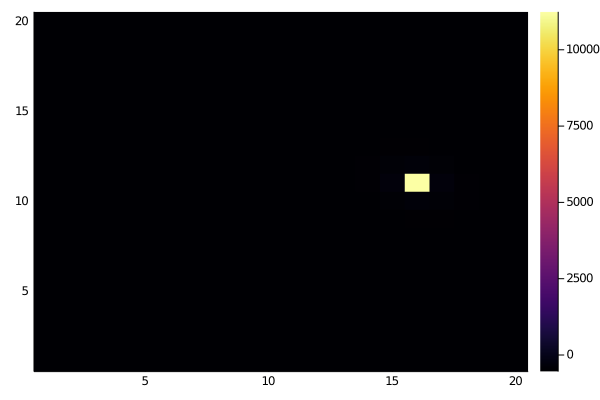

In [68]:
heatmap(logprob)

In [69]:
maximum(logprob)

11243.990212966017

In [70]:
argmax(logprob)

CartesianIndex(11, 16)

In [71]:
x_center = ceil(Int32, (size(observed,1)/2)+1.0)
y_center = ceil(Int32, (size(observed,2)/2)+1.0)

dx_estimated = argmax(logprob)[1] - x_center
dy_estimated = argmax(logprob)[2] - y_center
(dx_estimated, dy_estimated)

(0, 5)

# やること

- ピクセル数は典型的なAFM像の場合で固定
- ランダムに連続的な角度でAFM像を100個ほど生成
- ベスト構造を推定して答えからのRMSDを求める
- それを様々な「Quaternionの数」「probeRadius」「ノイズの大きさ」でプロット
